# Data Loading

In [30]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(10)
import matplotlib.pyplot as plt

# Load the dataset
import tensorflow_datasets as tfds
dataset, dataset_info = tfds.load(name='malaria', shuffle_files=True, with_info=True, as_supervised=True, split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'])

# Callbacks

In [31]:
from tensorflow.keras.callbacks import Callback,CSVLogger,EarlyStopping
class lossCallback(Callback):
    def on_epoch_end(self,epoch,logs):
        print(f"\n for epoch {epoch+1} loss is {logs['loss']}")
    # def on_batch_end(self,batch,logs):
    #     print(f"\n for batch {batch+1} loss is {logs['loss']}")

# CSV Logger

In [32]:
csv_logger = CSVLogger("logs.csv",separator=',',append=False)

# Early Stopping

In [33]:
es_callback = EarlyStopping(restore_best_weights=True,patience=1)

# LearningRate Scheduler

In [49]:
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

sched = LearningRateScheduler(scheduler, verbose=1)

In [46]:
# Preprocessing function
def preprocess(image, label):
    image = tf.image.resize(image, [224, 224])  # Resize images to 224x224
    image = tf.cast(image, tf.float32)  # Convert images to float32
    return image, label

# Apply preprocessing
train_dataset, valid_dataset, test_dataset = dataset

train_dataset = train_dataset.map(preprocess)
valid_dataset = valid_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

# Normalization function
def normalise(image, label):
    return image / 255.0, label

# Apply normalization
train_dataset = train_dataset.map(normalise)
valid_dataset = valid_dataset.map(normalise)
test_dataset = test_dataset.map(normalise)

# Apply shuffling, batching, and prefetching
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(100).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(100).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(100).prefetch(tf.data.AUTOTUNE)

In [47]:
from keras.layers import Conv2D,MaxPool2D,Dense,InputLayer,Flatten,BatchNormalization
model = keras.Sequential([
    InputLayer(shape= (224,224,3)),
    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid',activation='relu'),
    BatchNormalization(),
    MaxPool2D(strides=2),
    
    Conv2D(filters=18, kernel_size=3, strides=1, padding='valid',activation='relu'),
    BatchNormalization(),
    MaxPool2D(strides=2),

    Conv2D(filters=36, kernel_size=3, strides=1, padding='valid',activation='relu'),
    BatchNormalization(),
    MaxPool2D(strides=2),
    
    Conv2D(filters=48, kernel_size=3, strides=1, padding='valid',activation='relu'),
    BatchNormalization(),
    MaxPool2D(strides=2),
    
    Flatten(),
    
    Dense(1020,activation='relu'),
    Dense(680,activation='relu'),
    Dense(1,activation='sigmoid')
])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 109, 109, 18)   │           990 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 109, 109, 18)   │            72 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 54, 54, 18)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 52, 52, 36)     │         5,868 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 52, 52, 36)     │           144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 26, 26, 36)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 24, 24, 48)     │        15,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 24, 24, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 12, 12, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 6912)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1020)           │     7,051,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 680)            │       694,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           681 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,769,279 (29.64 MB)

 Trainable params: 7,769,063 (29.64 MB)

 Non-trainable params: 216 (864.00 B)

In [48]:
# Model Compilation
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from keras.metrics import Accuracy

model.compile(loss=BinaryCrossentropy(), optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])

In [32]:
history_lossCB = model.fit(train_dataset,validation_data=valid_dataset,epochs=3,callbacks=[lossCallback()])

Epoch 1/3
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8949 - loss: 0.2693
 for epoch 1 loss is 0.2207459807395935
221/221 ━━━━━━━━━━━━━━━━━━━━ 27s 118ms/step - accuracy: 0.8950 - loss: 0.2691 - val_accuracy: 0.4964 - val_loss: 1.6341
Epoch 2/3
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9552 - loss: 0.1266
 for epoch 2 loss is 0.12430525571107864
221/221 ━━━━━━━━━━━━━━━━━━━━ 29s 128ms/step - accuracy: 0.9552 - loss: 0.1266 - val_accuracy: 0.9267 - val_loss: 0.1856
Epoch 3/3
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.9649 - loss: 0.0986
 for epoch 3 loss is 0.09563253074884415
221/221 ━━━━━━━━━━━━━━━━━━━━ 77s 347ms/step - accuracy: 0.9649 - loss: 0.0986 - val_accuracy: 0.9474 - val_loss: 0.1524


In [24]:
history_logCB = model.fit(train_dataset,validation_data=valid_dataset,epochs=3,callbacks=[csv_logger])

Epoch 1/3
221/221 ━━━━━━━━━━━━━━━━━━━━ 23s 103ms/step - accuracy: 0.9714 - loss: 0.0851 - val_accuracy: 0.9467 - val_loss: 0.2043
Epoch 2/3
221/221 ━━━━━━━━━━━━━━━━━━━━ 23s 101ms/step - accuracy: 0.9808 - loss: 0.0575 - val_accuracy: 0.9372 - val_loss: 0.2094
Epoch 3/3
221/221 ━━━━━━━━━━━━━━━━━━━━ 23s 102ms/step - accuracy: 0.9862 - loss: 0.0411 - val_accuracy: 0.9329 - val_loss: 0.2205


In [17]:
history_logCB = model.fit(train_dataset,validation_data=valid_dataset,epochs=10,callbacks=[es_callback])

Epoch 1/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 33s 122ms/step - accuracy: 0.6940 - loss: 0.8943 - val_accuracy: 0.4982 - val_loss: 1.6013
Epoch 2/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 23s 104ms/step - accuracy: 0.9303 - loss: 0.1846 - val_accuracy: 0.9126 - val_loss: 0.2235


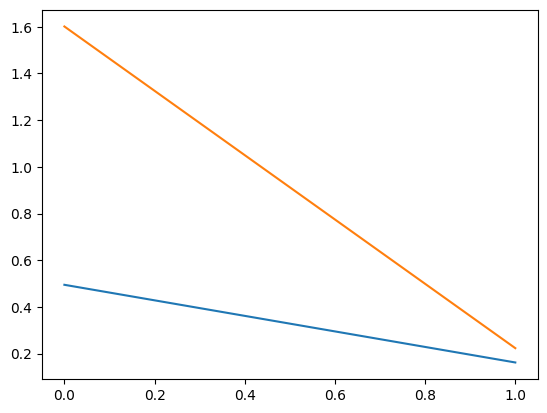

In [18]:
plt.plot(history_logCB.history['loss'])
plt.plot(history_logCB.history['val_loss'])

In [50]:
history_CB_lrs = model.fit(train_dataset,validation_data=valid_dataset,epochs=10,callbacks=[sched])


Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 1/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 183s 803ms/step - accuracy: 0.8328 - loss: 0.4424 - val_accuracy: 0.4898 - val_loss: 2.6056 - learning_rate: 5.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 2/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 175s 789ms/step - accuracy: 0.9541 - loss: 0.1265 - val_accuracy: 0.8748 - val_loss: 0.3688 - learning_rate: 5.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 3/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 174s 785ms/step - accuracy: 0.9659 - loss: 0.0932 - val_accuracy: 0.9459 - val_loss: 0.1739 - learning_rate: 5.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00045241869520395994.
Epoch 4/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 175s 787ms/step - accuracy: 0.9798 - loss: 0.0598 - val_accuracy: 0.9445 - val_loss: 0.1944 - learning_rate: 4.5242e-04

Epoch 5: LearningRateScheduler setting